In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
from matplotlib.tri import Triangulation

import ast

In [2]:
def parse_results(file_name):
    grid_search_results = []
    with open(file_name, 'r') as file:
        for line in file.readlines():
            if line[0:4] == '----':
                grid_search_results.append([])
                continue

            if line[0] == '(':
                fixed_line = '[' + line.strip().replace(') (', '), (') + ']'
                params = ast.literal_eval(fixed_line)
                nested = [list(zip(key.split(','), np.array(val).flatten())) for (key, val) in params]
                unnested = [item for sublist in nested for item in sublist]
                grid_search_results[-1].append({key: val for (key, val) in unnested})
                grid_search_results[-1].append([])
                grid_search_results[-1].append([])
                continue

            result = line

            if result[0] == '[':
                if result[1] == '(':
                    grid_search_results[-1][2].append(ast.literal_eval(result))
                else:
                    grid_search_results[-1][1].append(ast.literal_eval(result))

                continue

    grid_search_results = [(params, np.array(accs), np.array(aps)) for params, accs, aps in grid_search_results]
    return grid_search_results

In [46]:
fracs_mnum = 160

In [47]:
both_res = parse_results('./grid_search_results/arc_des_subset.txt')


In [129]:
frac2 = both_res[fracs_mnum*0:fracs_mnum*1]
frac3 = both_res[fracs_mnum*1:fracs_mnum*2]
frac4 = both_res[fracs_mnum*2:fracs_mnum*3]
frac6 = both_res[fracs_mnum*3:fracs_mnum*4]
frac8 = both_res[fracs_mnum*4:fracs_mnum*5]
# hyp_res = both_res[:len(both_res)//2]
# euc_res = both_res[len(both_res)//2:]
frac = frac8
hyp_res = frac[:len(frac)//2]
euc_res = frac[len(frac)//2:]

In [130]:
hyp_res[0][2].shape

(5, 100, 12)

In [131]:
hyp_params = np.array([p for p, _, _ in hyp_res])
hyp_accs = np.array([a for _, a, _ in hyp_res])
hyp_aps = np.array([a for _, _, a in hyp_res])

euc_params = np.array([p for p, _, _ in euc_res])
euc_accs = np.array([a for _, a, _ in euc_res])
euc_aps = np.array([a for _, _, a in euc_res])

# fix for fracs with multiple seeds
# hyp_params = hyp_params[[i for i in list(range(fracs_mnum)) if not (i//seeds_mnum)%2]]
# hyp_values = hyp_values[[i for i in list(range(fracs_mnum)) if not (i//seeds_mnum)%2]]

# euc_params = euc_params[[i for i in list(range(fracs_mnum)) if (i//seeds_mnum)%2]]
# euc_values = euc_values[[i for i in list(range(fracs_mnum)) if (i//seeds_mnum)%2]]

hyp_accs.shape, hyp_aps.shape, euc_accs.shape, euc_aps.shape

((80, 5, 100), (80, 5, 100, 12), (80, 5, 100), (80, 5, 100, 12))

In [132]:
hyp_params.shape

(80,)

In [133]:
# hyp_params = hyp_params.reshape([5,seeds_mnum])[0]
# hyp_values = hyp_values.reshape([5,seeds_mnum,5,20]).mean(axis=0)

# euc_params = euc_params.reshape([5,seeds_mnum])[0]
# euc_values = euc_values.reshape([5,seeds_mnum,5,20]).mean(axis=0)

# hyp_values.shape, euc_values.shape

In [134]:
NUM_HIDDEN_LAYERS = sorted(list(set([p['num_hidden_layers'] for p in hyp_params]).union(set([p['num_hidden_layers'] for p in euc_params]))))
LAYER_SIZE = sorted(list(set([p['layer_size'] for p in hyp_params]).union(set([p['layer_size'] for p in euc_params]))))
LR = sorted(list(set([p['lr'] for p in hyp_params]).union(set([p['lr'] for p in euc_params]))))
WD = sorted(list(set([p['weight_decay'] for p in hyp_params]).union(set([p['weight_decay'] for p in euc_params]))))

In [135]:
print(NUM_HIDDEN_LAYERS)
print(LAYER_SIZE)
print(LR)
print(WD)

[1, 2]
[32, 64, 128, 256, 512]
[0.01, 0.02]
[0.002, 0.005, 0.01, 0.02]


In [136]:
num_hidden_layers = np.array(NUM_HIDDEN_LAYERS).repeat(len(LAYER_SIZE))
layer_size = np.tile(LAYER_SIZE, len(NUM_HIDDEN_LAYERS))

In [ ]:
for i, wd in enumerate(WD):
    print(f'--------------- Weight Decay: {wd} ---------------')
    hyp_values_wd = hyp_aps.mean(axis=-1)[i::len(WD)]
    euc_values_wd = euc_aps.mean(axis=-1)[i::len(WD)]
    for i, lr in enumerate(LR):
        hyp_data = hyp_values_wd.mean(axis=1)[:,-1].reshape(-1,len(LR))[:,i]
        euc_data = euc_values_wd.mean(axis=1)[:,-1].reshape(-1,len(LR))[:,i]

        min_val = min(np.min(hyp_data), np.min(euc_data))
        max_val = max(np.max(hyp_data), np.max(euc_data))

        cmap = plt.cm.viridis
        norm = Normalize(vmin=min_val, vmax=max_val)


        num_hidden_layers_adjust = num_hidden_layers.astype(float)
        num_hidden_layers_adjust[num_hidden_layers_adjust == 0] = 0.5

        mesh = Triangulation(num_hidden_layers_adjust, layer_size)  #create tri mesh


        plt.figure(figsize=(15,8))
        plt.suptitle(f'Hyperbolic     |lr = {lr}|     Euclidean', fontsize=16, y=1)

        plt.subplot(121)
        plt.tricontourf(mesh, hyp_data, levels=40, cmap=cmap, norm=norm, alpha=0.75)
        plt.scatter(num_hidden_layers_adjust, layer_size, c=hyp_data, cmap=cmap, norm=norm)

        plt.title(f'Hyperbolic R2={np.max(hyp_data):.3f}')
        plt.xlabel('Num Hidden Layers')
        plt.ylabel('Layer Size')

        plt.xscale('log', base=2)
        plt.yscale('log', base=2)


        plt.subplot(122)
        euc_contourf = plt.tricontourf(mesh, euc_data, levels=40, cmap=cmap, norm=norm, alpha=0.75)
        euc_scatter = plt.scatter(num_hidden_layers_adjust, layer_size, c=euc_data, cmap=cmap, norm=norm)
        plt.colorbar(euc_scatter, label='R2')


        plt.title(f'Euclidean R2={np.max(euc_data):.3}')
        plt.xlabel('Num Hidden Layers')
        plt.ylabel('Layer Size')

        plt.xscale('log', base=2)
        plt.yscale('log', base=2)

        plt.tight_layout()
        plt.show()

<h1>BEST MODELS</h1>

<h3>Descriptors</h3>

<h5>1</h5>

- hyp: 0.44: 1 X [256,512], 0.01, [0.002,0.005], 50
- euc: 0.39: 1 X [128,256], 0.01,  0.01,         50

<h5>1/2</h5>

- hyp: 0.58: 1 X [512], 0.01, 0.005, 100+
- euc: 0.58: 1 X [128], 0.01, 0.002, 100+

<h5>1/3</h5>

- hyp: 0.52: 1 X [512], 0.01, 0.002, 100+
- euc: 0.49: 1 X [128], 0.01, 0.005, 100+

<h5>1/4</h5>

- hyp: 0.48: 1 X [512], 0.01, 0.002, 100+
- euc: 0.44: 1 X [128], 0.01, 0.005, 100+

<h5>1/6</h5>

- hyp: 0.42: 1 X [512], 0.01, 0.005, 100+
- euc: 0.39: 1 X [128], 0.01, 0.005, 100+

<h5>1/8</h5>

- hyp: 0.40: 1 X [512], 0.01, 0.02,  100+
- euc: 0.37: 1 X [128], 0.01, 0.005, 100+

<!-- 
<h3>Fingerprints</h3>

- hyp: 0.44: 1 X [256,512], 0.01, [0.002,0.005], 100
- euc: 0.43: 1 X [64,128],  0.01,  0.02,         100


<h3>Mass Spectra</h3>

- hyp: 0.31: 1 X [512],     [0.02,0.05], [0.002],      100
- euc: 0.32: 1 X [256,512], [0.01,0.02], [0.002,0.05], 100
 -->


In [137]:
hyp_values = hyp_aps.mean(axis=-1)
euc_values = euc_aps.mean(axis=-1)

In [138]:
K_HYP = 99
K_EUC = 99
reduce = np.mean


best_hyp_params = list(reversed(np.argsort(reduce(hyp_values, axis=1)[:,K_HYP])[-9:]))
print(reduce(hyp_values, axis=1)[:,K_HYP][best_hyp_params])
print()
best_euc_params = list(reversed(np.argsort(reduce(euc_values, axis=1)[:,K_EUC])[-9:]))
print(reduce(euc_values, axis=1)[:,K_EUC][best_euc_params])

best_hyp_runs = reduce(hyp_values, axis=1)[best_hyp_params]
best_euc_runs = reduce(euc_values, axis=1)[best_euc_params]

[0.39514528 0.39327568 0.39192732 0.39155322 0.39089267 0.38914077
 0.38859649 0.38853259 0.38638883]

[0.37199117 0.37015641 0.36713516 0.36605433 0.36432297 0.36409774
 0.36404432 0.36345927 0.36310017]


In [139]:
print(hyp_params[best_hyp_params])
print()
print(euc_params[best_euc_params])

[{'subset_frac': 0.125, 'subset_seed': 42, 'model_type': 'hyp', 'num_hidden_layers': 1, 'layer_size': 256, 'lr': 0.01, 'weight_decay': 0.02, 'batch_size': 1024, 'epochs': 100, 'curvature': -1}
 {'subset_frac': 0.125, 'subset_seed': 42, 'model_type': 'hyp', 'num_hidden_layers': 1, 'layer_size': 512, 'lr': 0.01, 'weight_decay': 0.02, 'batch_size': 1024, 'epochs': 100, 'curvature': -1}
 {'subset_frac': 0.125, 'subset_seed': 42, 'model_type': 'hyp', 'num_hidden_layers': 1, 'layer_size': 512, 'lr': 0.01, 'weight_decay': 0.005, 'batch_size': 1024, 'epochs': 100, 'curvature': -1}
 {'subset_frac': 0.125, 'subset_seed': 42, 'model_type': 'hyp', 'num_hidden_layers': 1, 'layer_size': 256, 'lr': 0.01, 'weight_decay': 0.01, 'batch_size': 1024, 'epochs': 100, 'curvature': -1}
 {'subset_frac': 0.125, 'subset_seed': 42, 'model_type': 'hyp', 'num_hidden_layers': 1, 'layer_size': 512, 'lr': 0.01, 'weight_decay': 0.01, 'batch_size': 1024, 'epochs': 100, 'curvature': -1}
 {'subset_frac': 0.125, 'subset_se

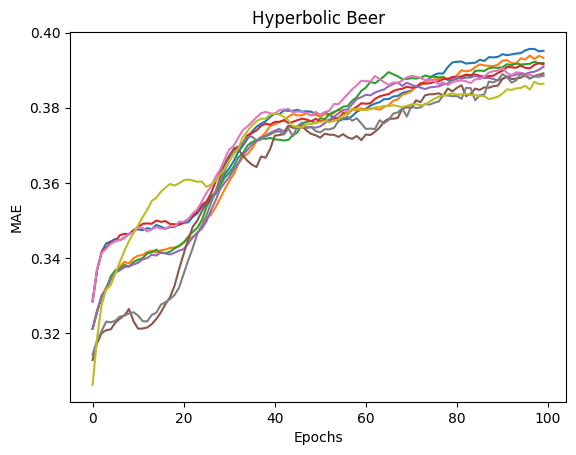

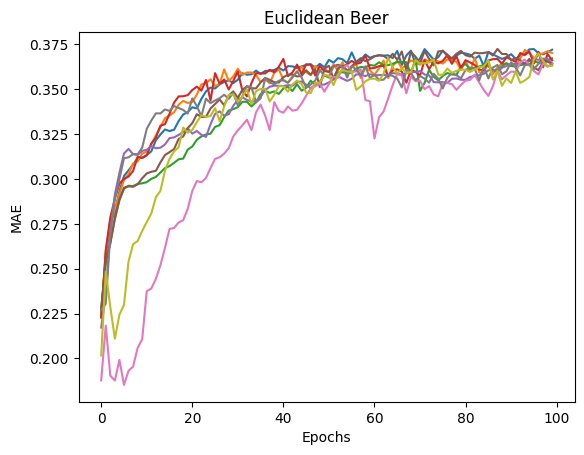

In [140]:
for run in best_hyp_runs:
    plt.plot(run)
    # plt.plot(run[25:])

plt.title('Hyperbolic Beer')
plt.ylabel('MAE')
plt.xlabel('Epochs')

# plt.ylim(0.03,0.07)
# plt.yscale('log')
plt.show()

for run in best_euc_runs:
    plt.plot(run)
    # plt.plot(run[25:])

plt.title('Euclidean Beer')
plt.ylabel('MAE')
plt.xlabel('Epochs')

# plt.ylim(0.03,0.07)
# plt.yscale('log')
plt.show()
